In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from operator import itemgetter
import sklearn.decomposition
from sklearn.neighbors import NearestNeighbors

### General helper functions

In [2]:
# Loading data and transforming it to pandas dataframe
def load_data(path, col_name):
    data = sio.loadmat(path)
    data = pd.DataFrame(data['Y'])
    return data

In [3]:
# Plot the data
def plotClusterOutput(Y, x1, x2):
    f1 = np.ravel(Y[x1, :])
    f2 = np.ravel(Y[x2, :])
    plt.scatter(f1, f2, c='blue', s=7)
    plt.show()

def plot_data(X, data_centers):
   
    # Add cluster centers to data points
    C = np.matrix(data_centers).T
    X = np.hstack((X, C))
    data = pd.DataFrame(X, columns=['x1', 'x2', 'c'])
   
    fig, ax = plt.subplots(figsize=(12,8))
   
    # Draw the plots
    ax.scatter(data.x1, data.x2, label='Data', c=data.c * 10)
   
    # Set extra properties for readability
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('x1 vs. x2')
    plt.show()

### Helper functions for K-means

In [4]:
# Assigns each data point to a centroid
def assignment(X, centroids):
    C = dict.fromkeys(range(X.shape[0]), np.inf)
    Z = {}
    for i in centroids.keys():
        for j in range(X.shape[0]):
            
            # Euclidean dist
            dist = abs(np.linalg.norm(X[j] - centroids[i]))
            
            # Change assignment if dist is lesser than previous
            if dist < C[j]:
                C[j] = dist
                Z[j] = i
    return Z

In [5]:
# Updates the centroids 
def update(centroids, X, Z):
    for i in centroids.keys():
        temp = []
        for j in range(X.shape[0]):
            if Z[j] == i:
                temp.append(X[j])
        centroids[i] = np.mean(temp, axis=0)
    return centroids

In [6]:
# Computes the cost after new centroid assignment
def compute_cost(centroids, X, Z):
    cost = 0
    for i in centroids.keys():
        temp = []
        for j in range(X.shape[0]):
            if Z[j] == i:
                temp.append(X[j])
                
        for k in range(len(temp)): 
            cost += abs(np.linalg.norm(temp[k] - centroids[i]))
    return cost

### K-means

In [7]:
def k_means(X, k, r):
    # Initialize metadata
    X = X.T
    clustering_run = {}
    tol = 0.00001
    
    # Iterate over given r
    for itr in range(r):
        cost = [np.inf]
        
        # Initialize random centroids
        centroids = {}
        rand = np.random.choice(len(X), k, replace=False)
        for i in range(len(rand)):
            centroids[i] = X[i, :]
        
        # Loop till you converge
        while True:
            # Alternate between assignment and update
            Z = assignment(X, centroids)
            centroids = update(centroids, X, Z)
            new_Z = assignment(X, centroids)
            cost.append(compute_cost(centroids, X, new_Z))
            
            # if change in cost is less than tol the break
            if cost[-2] - cost[-1] == 0:
                break
                
        clustering_run[cost[-1]] = new_Z
        
    return min(clustering_run.items(), key=itemgetter(0))[1]


### Helper functions for Spectral clustering

In [8]:
def Gaussian(x, z, variance):
    return np.exp((-(np.linalg.norm(x - z) ** 2)) / (2 * variance))

In [9]:
def GaussianKernel(X, variance):
    length = X.shape[0]
    K = np.zeros((length, length))
    
    for i in range(length):
        for j in range(length):
            K[i][j] = Gaussian(X[i], X[j], variance)
    return K

In [10]:
def generate_W(X, KNN, variance):
    X = X.T
    neigh = NearestNeighbors(n_neighbors=KNN)
    neighbors = neigh.fit(X)
    _, indices = neighbors.kneighbors(X)
    length = X.shape[0]
    W = np.zeros((length, length))
    for index in indices:
        current_index = index[0]
        current_point = X[current_index]
        for j in range(1, len(index)):
            neighbor_index = index[j]
            neighbor = X[neighbor_index]
            gaussian_dist = Gaussian(current_point, neighbor, variance)
            W[current_index][neighbor_index] = gaussian_dist
            W[neighbor_index][current_index] = gaussian_dist
    return W

### Specteral Clustering

In [11]:
def spectral(W, k):
    # Compute Diagonal matrix D
    D = np.diag(np.sum(W, axis=0))
    
    # Compute Laplace matrix L
    L = D - W
    
    # Eigen vector decomposition of L
    lam, V = np.linalg.eig(L)

    # Get k bottom eigen vectors of W
    bottom_eig = np.argsort(lam)
    bottom_eig = bottom_eig[:k]
    
    V1 = np.matrix(V[:,bottom_eig[0]]).T
    V2 = np.matrix(V[:,bottom_eig[1]]).T
    top_V = np.concatenate((V1, V2), axis=1)
    return k_means(top_V.T, k, 5)

### PCA for plotting

In [12]:
# Normalizes the data to get the mean to 0
def normalize_mean(Y):
    mu = Y.mean(0)
    Y = Y - mu
    return Y

def pca(Y, d):
    Y = Y.T

    # Normalize mean
    Y = normalize_mean(Y)

    # Find the correlation matrix
    C = (Y.T * Y) / Y.shape[0]

    # Do eigenvalue decomposition get the
    # eigenvalues(W) and eigenvectors(V) of 
    # covariance matrix
    W, V = np.linalg.eig(C)

    # Extract the top-d eigenvectors
    V = V[:, 0:d]
    
    # Represent data in this basis
    X = Y * V
    
    # Calculate the mean of low-dimensional space
    M_X = np.sum(X, axis=0) / X.shape[0]
    
    return V.T, M_X, X.T

#### MAIN

In [13]:
def main():
    data = load_data("HW3_Data/dataset2.mat", 'Y')
    X = np.matrix(data.values)
    Z = k_means(X, 2, 15)
    output = []
    # Get the output values from Z
    for key in Z:
        output.append(Z[key])
    U, mean, X_pca = pca(X, 2)
    plot_data(X_pca.T, output)
    
    
    # Spectral Clustering
    W = generate_W(X, 5, 0.4)
    Z_s = spectral(W, 2)
    output = []
    for key in Z_s:
        output.append(Z_s[key])
    plot_data(X_pca.T, output)

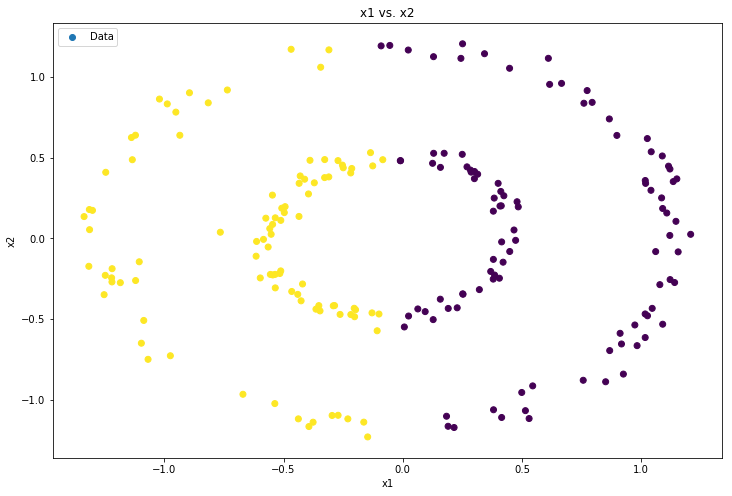

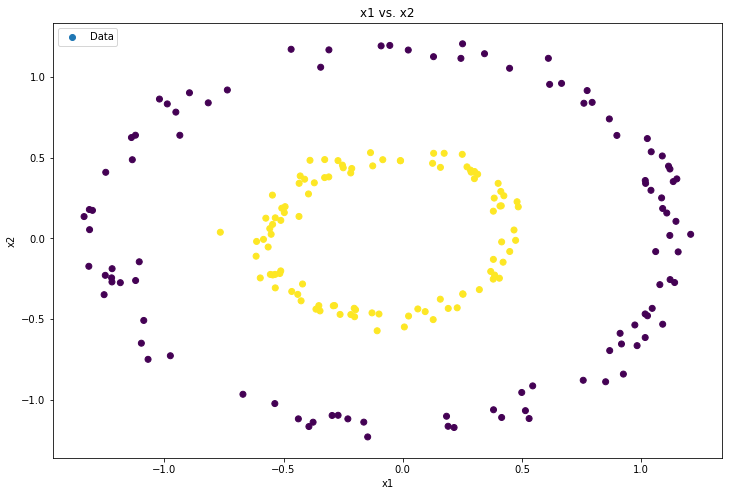

In [14]:
if __name__ == '__main__':
    main()